In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn import metrics
from pathlib import Path
from sklearn import svm
from osgeo import gdal
import seaborn as sn
import pandas as pd
import numpy as np
import rasterio
import pickle
import cv2

In [2]:
x_indian_p = loadmat('Indian_pines.mat')['indian_pines_corrected']
y_indian_p = loadmat('Indian_pines_gt.mat')['indian_pines_gt']

In [3]:
def normalize(raster, n = 5000):
    raster[raster>n]=n
    min_raster, max_raster, new_max, new_min = raster.min(), raster.max(), 255, 0
    return ((raster-min_raster)*((new_max-new_min)/(max_raster-min_raster))+new_min).astype(int)

(-0.5, 144.5, 144.5, -0.5)

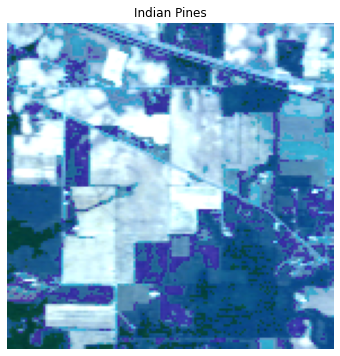

In [4]:
indian = np.dstack((
    x_indian_p[:, :, 29], #39
    x_indian_p[:, :, 20], #30
    x_indian_p[:, :, 11]  #12
)) 
plt.figure(figsize=(6, 6))
plt.imshow(normalize(indian))
plt.title("Indian Pines")
plt.axis('off')

In [5]:
data = x_indian_p.reshape(-1, x_indian_p.shape[2])
df_indian_p = pd.DataFrame(data=data)
df_indian_p = pd.concat([df_indian_p, pd.DataFrame(data = y_indian_p.ravel())], axis=1)
df_indian_p.columns= [f'band{i}' for i in range(1, 1 + x_indian_p.shape[2])]+['class']
df_indian_p.head()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band192,band193,band194,band195,band196,band197,band198,band199,band200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,...,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,...,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,...,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,...,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,...,1110,1107,1112,1094,1072,1087,1052,1034,1019,3


In [6]:
componets = 20
pca_indian = PCA(n_components = componets)
df_pca = pca_indian.fit_transform(df_indian_p.iloc[:, :-1].values)
df_pca_indian = pd.concat([pd.DataFrame(data = df_pca), pd.DataFrame(data = y_indian_p.ravel())], axis = 1)
df_pca_indian.columns = [f'PCA-{i}' for i in range(1, componets + 1)]+['class']
df_pca_indian.head()

,PCA-1,PCA-2,PCA-3,PCA-4,PCA-5,PCA-6,PCA-7,PCA-8,PCA-9,PCA-10,...,PCA-12,PCA-13,PCA-14,PCA-15,PCA-16,PCA-17,PCA-18,PCA-19,PCA-20,class
0,5014.905985,1456.863260,72.697043,71.205193,-435.686778,-68.841765,134.817314,-304.371911,256.435707,-66.660535,...,-29.223341,-121.148722,174.662139,-148.771270,156.825801,-51.453225,408.911368,-221.558515,-6.845843,3
1,5601.383743,-2023.450087,350.134640,-528.465575,148.088896,-288.355227,202.944817,240.826918,-474.865317,93.598524,...,-8.414434,-78.722778,31.625569,67.155992,-42.236253,-127.013112,-135.525038,163.815856,-41.362418,3
2,5796.135442,-3090.394852,490.539912,-760.214416,259.933567,-131.609925,172.923973,205.903796,572.488142,-191.601206,...,-58.654096,-22.291779,-78.526472,-46.875359,55.095690,-141.268442,-217.137148,104.708063,21.371299,3
3,5586.204575,-2369.376085,356.274683,-502.687252,146.556183,-306.678484,251.070797,234.944921,-314.029675,55.006602,...,35.093342,-46.448537,20.808344,146.015810,6.795843,-23.920368,-119.796896,155.298467,-20.743789,3
4,5020.990792,339.603390,-23.007562,-92.556338,-368.495435,-438.267060,502.717786,-345.548859,-188.358830,-67.564444,...,61.329182,57.562734,30.783550,26.052924,-66.974308,133.402755,139.110510,40.199609,-43.330956,3


In [7]:
print(f"Varianza de las principales {componets} componentes Pavia: \n{pca_indian.explained_variance_ratio_}, \n\ntotal: {sum(pca_indian.explained_variance_ratio_)}")

Varianza de las principales 20 componentes Pavia: 
[0.68493799 0.23531371 0.01496355 0.00821542 0.00695011 0.00517011
 0.00399681 0.0036236  0.00307127 0.00293212 0.00267353 0.0024923
 0.00224688 0.00189388 0.00169433 0.00156043 0.00153162 0.00135011
 0.00100119 0.00092438], 

total: 0.9865433484113324


In [8]:
class_imprt = df_pca_indian[df_pca_indian['class'] != 0]
(indian_train, 
 indian_test, 
 indian_y_train, 
 indian_y_test) = train_test_split(class_imprt.iloc[:, :-1],
                                   class_imprt.loc[:, 'class'],
                                   test_size=0.8, 
                                   random_state=42)

In [10]:
(len(indian_y_train),
len(indian_y_test))

(2049, 8200)

In [ ]:
svm_indian =  svm.SVC(C=100, kernel='rbf', cache_size=10*1024)

In [ ]:
%%time
svm_indian.fit(indian_train, indian_y_train.ravel()) # Wall time: 1min 30s

In [ ]:
%%time
y_pred_in = svm_indian.predict(indian_test) # Wall time: 15.6 s

In [ ]:
# Model Accuracy: how often is the classifier correct?
print("Precisión Indian Pines :",metrics.accuracy_score(y_pred_in, indian_y_test))

In [ ]:
out_indian = confusion_matrix(indian_y_test, y_pred_in)
out_indian = np.round(out_indian/out_indian.max(), 2)

In [ ]:
names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture', 'Grass-trees',
'Grass-pasture-mowed', 'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
'Soybean-clean', 'Wheat', 'Woods', 'Buildings Grass Trees Drives', 'Stone Steel Towers']
df_cm = pd.DataFrame(out_indian, columns=np.unique(names), index = np.unique(names))
plt.figure(figsize=(18, 10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, cmap="Greens", annot=True, annot_kws={"size": 16}) # font size
plt.title("Confusion matrix")
plt.show()

In [ ]:
total_pred_in = svm_indian.predict(class_imprt.iloc[:, :-1])
df_indian_p['class_pred'] = df_indian_p['class']

# seting the predicted value
df_indian_p.iloc[class_imprt.index, -1] = total_pred_in
recompose_image = df_indian_p.class_pred.to_numpy().reshape(y_indian_p.shape)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
im1 = axes[0].imshow(y_indian_p, extent=(-5,5,-5,5), aspect='auto', cmap='gist_ncar')
tx1 = axes[0].set_title("Indian Pines\nactual classification")
im2 = axes[1].imshow(recompose_image, extent=(-5,5,-5,5), aspect='auto', cmap='gist_ncar')
tx2 = axes[1].set_title("Indian Pines\npredicted classification")
# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
bar = fig.colorbar(im2, cax=cbar_ax, ticks=range(17))

In [ ]:
for i in ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture', 'Grass-trees',
'Grass-pasture-mowed', 'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
'Soybean-clean', 'Wheat', 'Woods', 'Buildings Grass Trees Drives', 'Stone Steel Towers']:
    print(i,', ',sep='')